<a href="https://www.kaggle.com/walessonalves/fake-news-detection?scriptVersionId=87726228" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

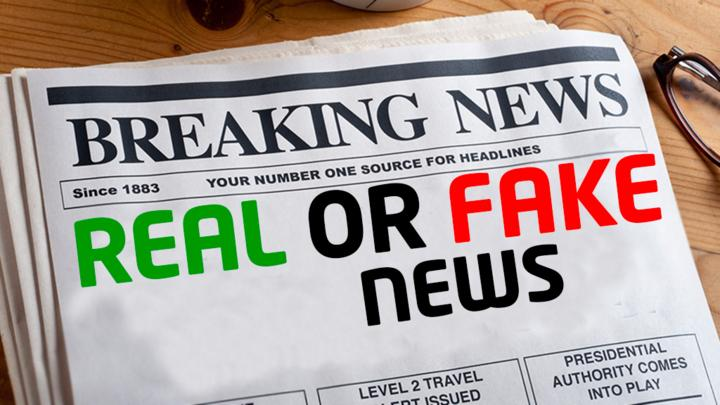!

## Estudo de caso para realização do Trabalho de Conclusão de Curso

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fakebr-corpus/FakeBr.csv


In [2]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from random import randint
from nltk import stem
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix

## Importação do Dataset

In [3]:
df = pd.read_csv('/kaggle/input/fakebr-corpus/FakeBr.csv')

**Análise do Dataset**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   7200 non-null   object
 1   Fake    7200 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.6+ KB


In [5]:
df.head(20)

,texto,Fake
0,Kátia Abreu diz que vai colocar sua expulsão e...,1
1,"Dr. Ray peita Bolsonaro, chama-o de conservad...",1
2,Reinaldo Azevedo desmascarado pela Polícia Fed...,1
3,Relatório assustador do BNDES mostra dinheiro ...,1
4,"Radialista americano fala sobre o PT: ""Eles ve...",1
5,Willian Waack continuará internado no Sírio Li...,1
6,Problema cardíaco tira William Waack do Jornal...,1
7,Edir Macedo poderá disputar as eleições presid...,1
8,"Boechat sobre Lula: ""Sua ALMA pode ser honesta...",1
9,PT diz que Lula não tem dinheiro para sobreviv...,1


<AxesSubplot:xlabel='Fake', ylabel='count'>

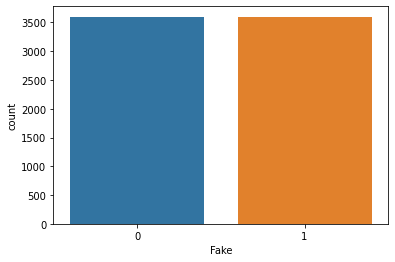

In [6]:
sns.countplot(x=df['Fake'])

# Feature "Fake" = "1": Sim, "0": Não

In [7]:
df['Fake'].unique()

array([1, 0])

In [8]:
df['Fake']

0       1
1       1
2       1
3       1
4       1
       ..
7195    0
7196    0
7197    0
7198    0
7199    0
Name: Fake, Length: 7200, dtype: int64

In [9]:
df.columns

Index(['texto', 'Fake'], dtype='object')

In [10]:
df

,texto,Fake
0,Kátia Abreu diz que vai colocar sua expulsão e...,1
1,"Dr. Ray peita Bolsonaro, chama-o de conservad...",1
2,Reinaldo Azevedo desmascarado pela Polícia Fed...,1
3,Relatório assustador do BNDES mostra dinheiro ...,1
4,"Radialista americano fala sobre o PT: ""Eles ve...",1
...,...,...
7195,"Para jornal britânico, ação contra Lula na Lav...",0
7196,Temer diz que acionou PF e Cade para investiga...,0
7197,Os obstáculos políticos de Temer em 2017. Espe...,0
7198,"Sexta-feira, 15 de setembro de 2017. Boa noite...",0


In [11]:
df.isnull().sum()

texto    0
Fake     0
dtype: int64

In [12]:
df.columns

Index(['texto', 'Fake'], dtype='object')

In [13]:
df.head(10)

,texto,Fake
0,Kátia Abreu diz que vai colocar sua expulsão e...,1
1,"Dr. Ray peita Bolsonaro, chama-o de conservad...",1
2,Reinaldo Azevedo desmascarado pela Polícia Fed...,1
3,Relatório assustador do BNDES mostra dinheiro ...,1
4,"Radialista americano fala sobre o PT: ""Eles ve...",1
5,Willian Waack continuará internado no Sírio Li...,1
6,Problema cardíaco tira William Waack do Jornal...,1
7,Edir Macedo poderá disputar as eleições presid...,1
8,"Boechat sobre Lula: ""Sua ALMA pode ser honesta...",1
9,PT diz que Lula não tem dinheiro para sobreviv...,1


## Função para tratamento do texto

In [14]:
# Regex
REPLACE_BY_SPACE_RE = re.compile('[/(),.;!"?\':%&+¤]')      # Remover simbolos ruins
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ]')                   # Remover tudo que não for número e letra

# Stopwords em português
STOPWORDS = set(stopwords.words('portuguese'))              # Carregando stopwords em portugues 

# Stemmer
stemmer = stem.RSLPStemmer()                                # Carregando stemmer

# Função para substituação de caracteres acentuados
def strip_accents(text):
  try:
    text = unicode(text, 'utf-8')
  except (TypeError, NameError):  
    pass
  text = unicodedata.normalize('NFD', text)
  text = text.encode('ascii', 'ignore')
  text = text.decode("utf-8")
  return str(text)

# Pré-processamento completo
def pre_process(text):
  text = text.lower()
  text = strip_accents(text)
  text = REPLACE_BY_SPACE_RE.sub(' ', text)
  text = BAD_SYMBOLS_RE.sub(' ', text)
  text = ' '.join(stemmer.stem(word) for word in text.split() if word not in STOPWORDS)
  return text

In [15]:
df['texto'][1]

'Dr. Ray peita Bolsonaro, chama-o de \x93conservador fake\x94 em entrevista a Danilo Gentili e divide a direita.\n\nEste site vem avisando Jair Bolsonaro que ele deveria abandonar a pauta estatista de vez e fazer um discurso mais convincente para aquela boa parte dos liberais e conservadores do Brasil que querem se ver livres das amarras estatais.\n\nTudo bem que as pesquisas ainda dizem que a maior parte do povo é contra as privatizações, mas o índice (pouco mais de 50% do povo) é fácil de ser revertido. Ademais, Bolsonaro deveria falar para direitistas em vez de focar tanto em petistas arrependidos.\n\nRecentemente ele disse que \x93pensaria 200 vezes antes de privatizar a Petrobrás para que ela não caia nas mãos de chineses\x94 (ou algo do tipo). Deveria ter dito: \x93Eu garanto a privatização da Petrobrás, e também garanto que chineses não irão comprá-la\x94. Isso não deixaria brechas. Do jeito que ele falou, parece que o suposto \x93medo de venda aos chineses\x94 é pretexto para e

In [16]:
pre_process(df['texto'][1])

'dr ray peit bolsonar cham conserv fak entrev danil gentil divid direit sit vem avis jair bolsonar dev abandon paut estat vez faz discurs convinc boa part liberal conserv brasil quer ver livr amarr estatal tud bem pesquis aind diz mai part pov contr privatizaco indic pouc 50 pov facil ser revert adem bolsonar dev fal direit vez foc tant petist arrepend recent diss pens 200 vez ant priva petrobr nao cai mao chines alg tip dev ter dit garant privatizaca petrobr tamb garant chines nao ira compr la nao deix brech jeit fal parec supost med vend chines pretext evit privatizaca la direit vai ter adot altern foqu est reduz diminuica impost vend estatal alem joa amoed dr rey faz vicej tip discurs aind candidat fas inic complic bolsonar aparec pesso direit prop visa economic direit econom enfim vej 32 40 dr rey espinafr bolsonar brech nao pod reclam outr aproveit nao'

## Extração das features

In [17]:
X = df['texto']
y = df['Fake']

In [18]:
X = X.apply(pre_process)

In [19]:
print(X[3])

relatori assust bnd mostr dinh publ brasil jorr pais comun relatori intitul bnd transform robin hood avess mostr bnd influenci govern petist consegu benefici pequen percent empr escolh ded afund instituica div astronom autor deput cristian brasil document apresent cpi bnd mostr pt aposs banc conced benefici pais comun trech document destac existenc contrat secret suspeit pra ato corrupca criaca empr fach benefici pais cub angol venezuel republ dominic guatemal outr cristian apont gam irregular concessa credit relat nao respeit proced propr instituica tampouc lei regulament operaco precis urgent derrub sigil dess contrat secret desmascar vez pilantr feit dinh publ abaix resum document text ofic voc pod confer sit cam feder ha divers suspeit irregular are internac send audit contrat cerc r 300 milho aprov diret respec pouc paragraf utilizaca term gener abstrat analis especif sobr obr ser realiz ped financ realizaca obr distint pais difer sao aprov pratic mesm fundamentaca utilizaca mesm 

## Separando treino e teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Conversão da feature "news" para vetores

In [21]:
# Instanciando TFIDF
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [22]:
#fidf.vocabulary_

In [23]:
tfidf.idf_

array([5.00937192, 4.51916559, 8.90119222, ..., 8.90119222, 8.20804504,
       8.90119222])

## Machine Learning

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
pred_lr=LR.predict(X_test)

In [26]:
print("Acurácia:", accuracy_score(y_test, pred_lr))

Acurácia: 0.9461111111111111


In [27]:
LR.score(X_test, y_test)

0.9461111111111111

In [28]:
cm = confusion_matrix(y_test, pred_lr)

In [29]:
print(cm)

[[833  52]
 [ 45 870]]


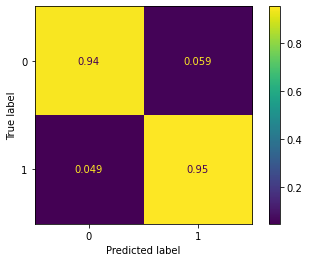

In [30]:
plot_confusion_matrix(LR, X_test, y_test, normalize="true")

In [31]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       885
           1       0.94      0.95      0.95       915

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



## Decision Tree CLassifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [33]:
dt = DecisionTreeClassifier(random_state=0, max_depth=8)
dt.fit(X_train, y_train)
pred_dt=dt.predict(X_test)

In [34]:
print("Acurácia:", accuracy_score(y_test, pred_dt))

Acurácia: 0.9


In [35]:
dt.score(X_test, y_test)

0.9

In [36]:
import pylab

In [37]:
#pylab.figure(figsize=(15,10))
#tree.plot_tree(dt)

In [38]:
cm = confusion_matrix(y_test, pred_dt)

In [39]:
print(cm)

[[804  81]
 [ 99 816]]


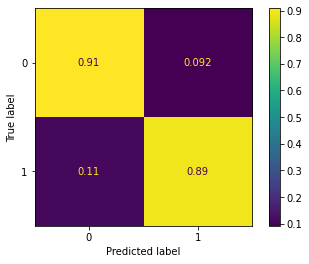

In [40]:
plot_confusion_matrix(dt, X_test, y_test, normalize="true")

In [41]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       885
           1       0.91      0.89      0.90       915

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



## Random Forest Classifier

In [42]:
from matplotlib import pyplot as plt

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [45]:
rf.score(X_test, y_test)

0.9488888888888889

In [46]:
print("Acurácia:", accuracy_score(y_test, pred_rf))

Acurácia: 0.9488888888888889


In [47]:
cm = confusion_matrix(y_test, pred_rf)

In [48]:
print(cm)

[[831  54]
 [ 38 877]]


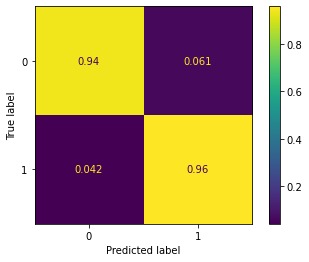

In [49]:
plot_confusion_matrix(rf, X_test, y_test, normalize="true")

In [50]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       885
           1       0.94      0.96      0.95       915

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



-------------------------------------------------